In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys

sys.path.insert(0, 'code')

In [5]:
import json

import torch
import numpy as np
from easydict import EasyDict as edict
from PIL import Image
from mac import MACNetwork
from utils import IntermediateLayerGetter, load_vocab
from datasets import GQADataset, collate_fn_gqa, ClevrDataset, collate_fn
from visualize_attentions import plot_word_img_attn, idxs_to_question

In [53]:
cfg = {'COMET_PROJECT_NAME': 'gqa',
 'CUDA': True,
 'DATASET': {'COGENT': '',
             'DATASET': 'gqa',
             'DATA_DIR': '/storage1/datasets/GQA/data'},
 'EVAL': False,
 'GPU_ID': '0',
 'LOGDIR': 'ffqi_nb1_no_stem_gqa_512_4',
 'SAMPLE': False,
 'TEST': False,
 'TEST_BATCH_SIZE': 256,
 'TRAIN': {'BATCH_SIZE': 256,
           'CLIP': 8,
           'CLIP_GRADS': True,
           'EALRY_STOPPING': True,
           'FLAG': True,
           'LEARNING_RATE': 0.0004,
           'MAX_EPOCHS': 45,
           'PATIENCE': 5,
           'RADAM': False,
           'SNAPSHOT_INTERVAL': 5,
           'VAR_DROPOUT': False,
           'WEIGHT_INIT': 'xavier_uniform'},
 'WORKERS': 1,
 'cfg_file': 'cfg/nb1_no_stem_gqa.yaml',
 'exp_name': 'ffqi_nb1_no_stem_gqa_512_4',
 'logcomet': False,
 'manualSeed': 5156,
 'model': {'common': {'module_dim': 512},
           'control_unit': {'control_cont_activation': 'TANH',
                            'control_feed_prev': True},
           'init_mem': 'random',
           'input_unit': {'bidirectional': True,
                          'in_channels': 2048,
                          'rnn_dim': 512,
                          'separate_syntax_semantics_embeddings': False,
                          'stem_act': 'ELU',
                          'use_stem': False,
                          'wordvec_dim': 300},
           'max_step': 4,
           'output_unit': {},
           'read_unit': {'film_from': 'qi',
                         'in_channels': 2048,
                         'num_blocks': 1,
                         'use_stem': False},
           'separate_syntax_semantics': False,
           'write_unit': {'gate': False,
                          'gate_shared': False,
                          'rtom': False,
                          'self_attn': False}},
 'resume_model': None,
 'resume_model_ema': None,
 'start_epoch': None}

cfg = edict(cfg)

dataset = cfg.DATASET.DATASET
cfg.DATASET.DATASET = dataset

if dataset == 'clevr':
    dataset_root = '/storage1/datasets/CLEVR_v1.0/'
#     data_dir = os.path.join(dataset_root, 'data')
    data_dir = os.path.join(dataset_root, 'features')
    images_dir = os.path.join(dataset_root, 'images')
elif dataset == 'gqa':
    dataset_root = '/storage1/datasets/GQA/'
    data_dir = os.path.join(dataset_root, 'data')
    images_dir = os.path.join(dataset_root, 'images')
    
cfg.DATASET.DATA_DIR = data_dir

In [54]:
split = 'val'
if cfg.DATASET.DATASET == 'gqa':
    ds = GQADataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
    )
    with open(os.path.join(data_dir, f'balanced_{split}_data.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
        
elif cfg.DATASET.DATASET == 'clevr':
    ds = ClevrDataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
    )
    with open(os.path.join(dataset_root, 'questions', f'CLEVR_{split}_questions.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
    
vocab = load_vocab(cfg)
reverse_word_dic = vocab['question_token_to_idx']
reverse_answer_dic = vocab['answer_token_to_idx']
num_answers = len(reverse_answer_dic)

model = MACNetwork(cfg, vocab, num_answers=num_answers)
state = torch.load('/storage1/fcorencoret/FiLMac/data/ffqi_nb1_no_stem_gqa_512_4/Model/model_checkpoint_000015.pth', map_location='cpu')
model.load_state_dict(state['model'])
model.eval()

return_layers = {
    'mac.control.cw_attn_idty': 'cw_attn',
    'mac.read.kb_attn_idty': 'kb_attn',
    'mac.read.res_block_idty' : 'res_block_idty',
    'input_unit.features_idty' : 'features_idty',
    'input_unit.stem_idty' : 'stem_idty'
}
mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=True)

num_steps = cfg.model.max_step

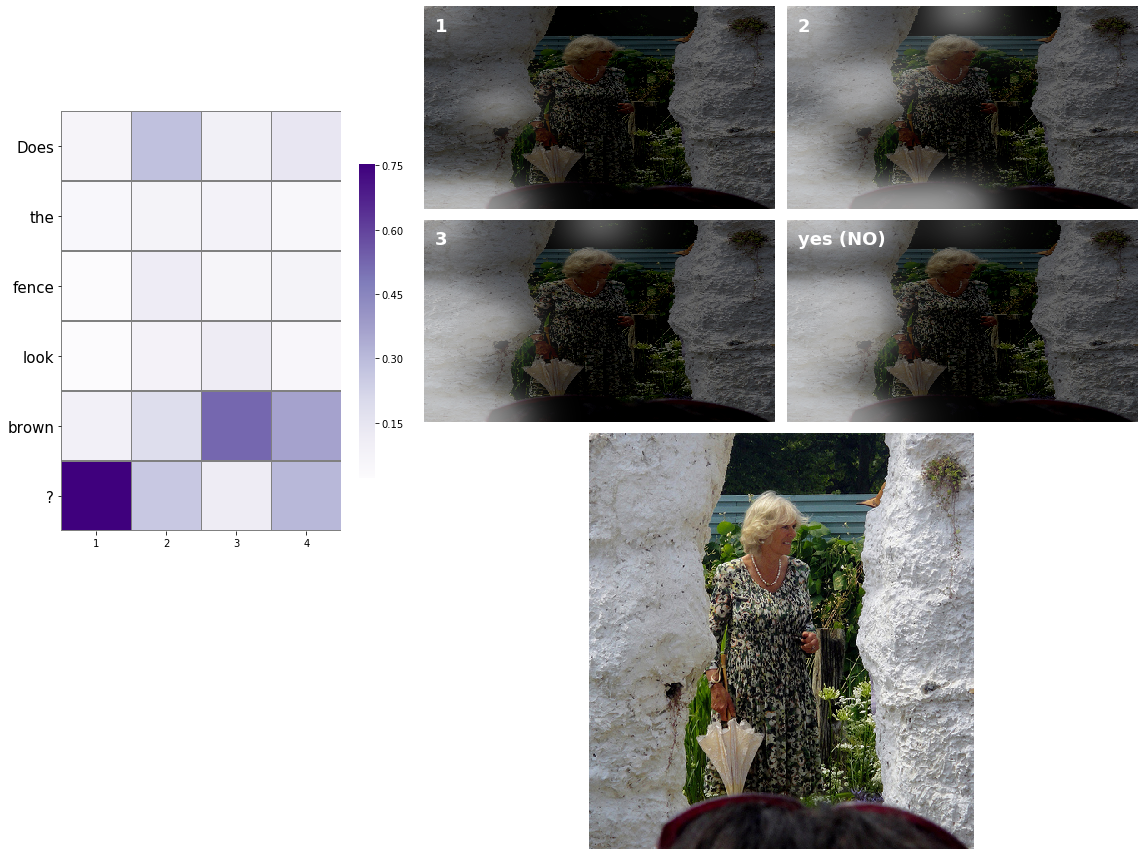

In [63]:
q_index = 520

if dataset == 'gqa':
    b = collate_fn_gqa([ds[q_index]])
    image_filename = ds.questions[q_index]['imageId'] + '.jpg'
elif dataset == 'clevr':
    b = collate_fn([ds[q_index]])
    image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])
    
with torch.no_grad():
    mid_outputs, output = mid_getter(b['image'], b['question'], b['question_length'],)

pred = vocab['answer_idx_to_token'][output.argmax().item()]
gt = vocab['answer_idx_to_token'][b['answer'].item()]

tokenized_questions = idxs_to_question(b['question'][0].numpy(), vocab['question_idx_to_token'])

plot_word_img_attn(
    mid_outputs,
    num_steps,
    tokenized_questions,
    images_dir,
    image_filename,
    pred,
    gt,
    vis='attn'
)

In [64]:
import matplotlib.pyplot as plt

In [65]:
mid_outputs['features_idty'].shape

torch.Size([1, 2048, 7, 7])

0.5945172991071429


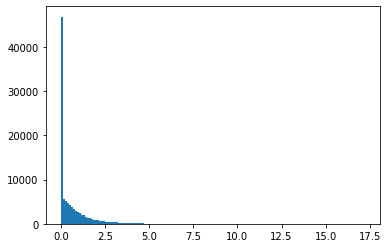

In [66]:
data = mid_outputs['features_idty'].cpu().numpy().flatten()
print((data != 0).sum() / len(data))
plt.hist(data.flatten(), bins=150);

In [67]:
# data = mid_outputs['stem_idty'].cpu().numpy().flatten()
# print((data > -0.9).sum() / len(data))
# plt.hist(data.flatten(), bins=150);

0.04922672193877551


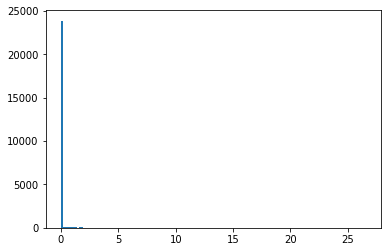

In [68]:
data = mid_outputs['res_block_idty'][0].cpu().numpy().flatten()
print((data != 0).sum() / len(data))
plt.hist(data.flatten(), bins=150);

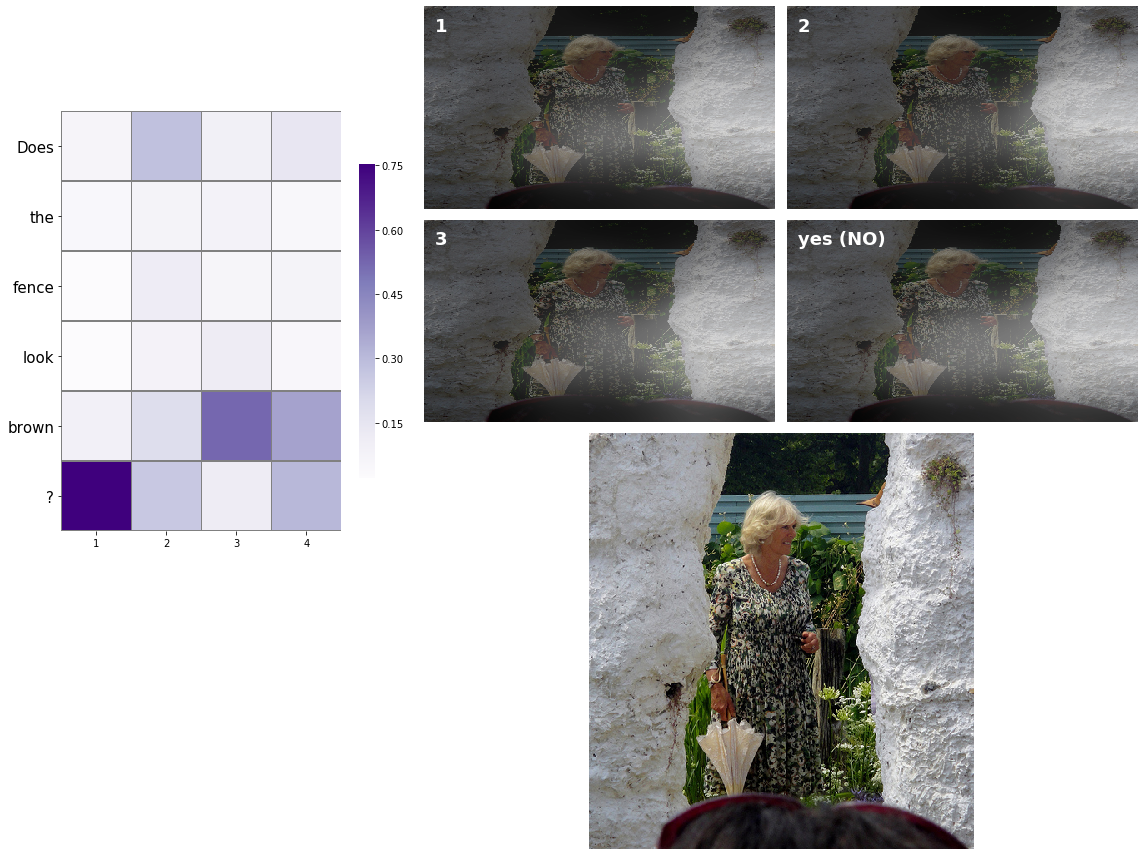

In [69]:
plot_word_img_attn(
    mid_outputs,
    num_steps,
    tokenized_questions,
    images_dir,
    image_filename,
    pred,
    gt,
    vis='know'
)